# 1. Reinforcement Learning: A High-Level Overview

Reinforcement Learning (RL) is a framework where an agent (like an AI) learns to make decisions by interacting with an environment. The learning process happens through a continuous cycle of observation, action, and feedback.

Here's a breakdown of the core components:

-   The Agent: The learner and decision-maker (e.g., an AI controlling Mario).

-   The Environment: The world in which the agent operates (e.g., the entire level of a Mario game).

-   The State (s): A representation of the environment at a specific time. This is the "observation" the agent uses to decide its next move. States can be:

    -   Raw Pixels: A screenshot of the game screen, which is a high-dimensional input.

    -   Vector Form: A low-dimensional set of relevant features (e.g., Mario's velocity, the distance to the nearest enemy, the agent's own health).

-   The Action (a): A move the agent can take. In a game, this could be JUMP, RUN_RIGHT, ATTACK, or a combination of buttons.

-   The Reward (r): A scalar feedback signal from the environment after each action. The agent's ultimate goal is to maximize the total cumulative reward it receives over time (e.g., getting a positive reward for collecting a coin and a negative reward for falling into a pit).

The RL Loop
The agent continuously repeats this cycle:

-   Observes the current state s from the environment.

-   Selects and executes an action a based on that state.

-   Receives a new state s' and a reward r from the environment.

-   Learns from this experience (s, a, r, s') to improve its future decisions.


![Classical RL](classical_rl.png)


Applying this to our Mario Bros. Example
In our specific case of training an agent to play Mario Bros.:

-   Agent: The AI controlling Mario.

-   Environment: The Mario game level.

-   State: We have chosen to use an image of the game environment (a sequence of frames) as our state. This is a powerful but complex approach, as the agent must learn to interpret visual information. We will discuss later how we can preprocess these images to make learning more efficient.

-   Action: Commands like JUMP, MOVE_RIGHT, or MOVE_LEFT.

-   Reward: The in-game score, which increases for actions like defeating enemies or collecting coins.

# 2. Mario Overview 🍄

In [1]:
import os
import warnings
os.environ['PYTHONUNBUFFERED']='1'
warnings.filterwarnings('ignore')

**2.1 Controls**

the following controls are provided by NES Emulator which will help to have much easier control over mario game

| Key | Meaning |
| :---- | :---: |
| NOOP | No Operation  🚫|
| right | Right 👣|
| A | Jump  🍄|
| B | Run  🏃💨|
| left | Left 👣

In [2]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

env = gym_super_mario_bros.make("SuperMarioBros-v0",new_step_api=True)
print("Number of normal action space: ",env.action_space.n)
env = JoypadSpace(env, SIMPLE_MOVEMENT);
print("Number of Simplified action space: ",env.action_space.n)

SIMPLE_MOVEMENT

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Number of normal action space:  256
Number of Simplified action space:  7


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [3]:
import gym
print(gym.__version__)

0.25.2


**2.2 Action Sample**

if we did not use `SIMPLE_MOVEMENT` action space we would have 256 possible action spaces, that would take ages to train an Agent to play the game, this is why we went for `SIMPLE_MOVEMENT`

**2.1 Checking Step() function**

In [4]:
state = env.reset()
print("State Shape: ",state.shape)
print("Type of State: ",type(state))
print("Number of items returned by step(): ",len(env.step(1)))

#new api now returns terminated,truncated instead of just Done
#terminated: whether goal has been reached or user has lost
#truncated: whether the time limit has passed/max number of steps

state,reward,terminated,truncated,info = env.step(1)
done = terminated or truncated
print("reward: ",reward)
print("terminated: ",terminated)
print("truncated: ",truncated)
print("done: ",done)
print(info)

State Shape:  (240, 256, 3)
Type of State:  <class 'numpy.ndarray'>
Number of items returned by step():  5
reward:  0.0
terminated:  False
truncated:  False
done:  False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


**2.2 Checking Render() function**

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


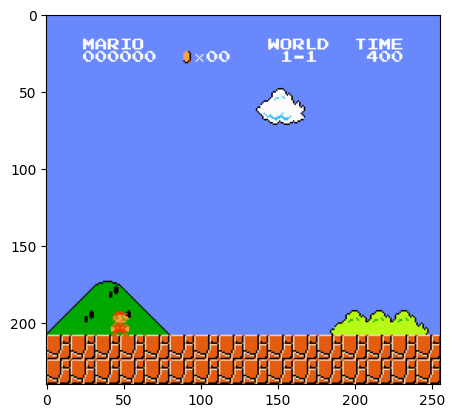

In [5]:
import matplotlib.pyplot as plt

state_rgb=env.render(mode='rgb_array');
plt.imshow(state_rgb);

# 3. Data Preprocessing

**3.0 Frame Preprocessing: Greyscaling and Stacking**

We process the game frames to make training more efficient and effective.

1. `Time Limit:` determines the maximum length of episode, original one for mario is 400 timesteps, however sometimes agent gets stuck, trying to jump over a pipe, if we is stuck for too much this wastes our training time, hence we should terminate earlier

1.  `Grayscaling:` Converting the image from color to grayscale reduces the data the AI must process from three color channels to one. This speeds up training significantly.

2. `DownSampling`: downsamping would decrease height,width of image shrinking it down, this makes training faster



4.  `Frame Stacking:` A single frame doesn't show movement. By stacking several consecutive frames, the AI can detect motion—like which way an enemy is moving or Mario is jumping. This solves a key problem: without a sequence of frames, the game state is "partially observable," violating the assumptions of a Markov Decision Process. Stacking frames creates a state that includes recent history, making the environment suitable for Reinforcement Learning.

5. `Frame Skipping:` It is a technique where agent takes an action for frame t, and repeat it for n number of frames, it is useful as it increases learning stability via making agent focus on marco strategy rather than micro strategy also known as `Temporal Abstraction`, where agent focuses on higher objective rather than small objective every timestep, such as for state s, take right, for state st+1, take left, for state st+2 take right, might lead to jittery behaviour if frame skipping was not used, also it speeds up training as Neural networks require a lot of resources to train, skipping calling Network every couple of frames speeds up learning, downside that it introduces hyperparameter which might need tweaking, and it is not recommended for games with fine-controls, where slightlest action or small move is important

![Stacked Frames Example](stacked_frames.png)


**3.1 Time Limit**

In [6]:
class GameTimeLimit(gym.Wrapper):
    def __init__(self,env):
        super().__init__(env)
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        if info["time"] == 200:
            terminated=True
            truncated=True
        return obs, reward, terminated, truncated, info

**3.2 Grayscaling**

using grayscaling technique would cut down information from `240x256x3 =>  184320`  to  `240x256x1 => 61440`, a reduction in information by about
`66.67%`

In [7]:
def DisplayComparsion(new_mode_text=""):
    fig, (ax_changed, ax_original_rgb) = plt.subplots(1,2, figsize=(10,8))
    state_grayscale = env.reset()
    state_rgb=env.render(mode='rgb_array');
    
    ax_changed.imshow(state_grayscale, cmap="gray");
    ax_changed.set_title(new_mode_text);
    ax_original_rgb.imshow(state_rgb);
    ax_original_rgb.set_title("Original Mario State");

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


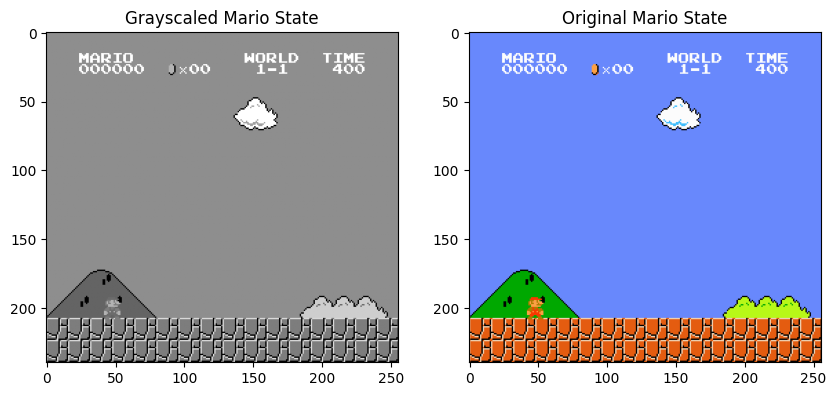

In [8]:
from gym.wrappers import  GrayScaleObservation, HumanRendering, StepAPICompatibility, ResizeObservation, FrameStack, NormalizeObservation

# 1. Creating Environment
env = gym_super_mario_bros.make("SuperMarioBros-v0",new_step_api=True);
# 2. Simplifying Controls
env = JoypadSpace(env, SIMPLE_MOVEMENT);
# 3. Grayscale Wrapper
env = GrayScaleObservation(env, keep_dim=True);

DisplayComparsion("Grayscaled Mario State")

**3.3 DownScaling**


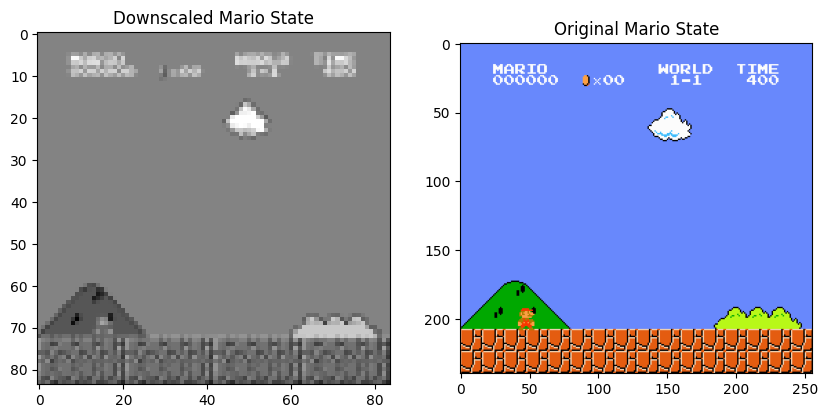

In [9]:
env = ResizeObservation(env, 84)
DisplayComparsion("Downscaled Mario State")


**3.5 Frame Stacking**


In [20]:
def DisplayStackFrames(state):
    number_of_frames=state.shape[0]
    
    fig,ax= plt.subplots(1,number_of_frames, figsize=(20, 15))
    flattened_axes = ax.flatten()
    for i, ax in enumerate(flattened_axes):
        ax.imshow(state[i], cmap='gray')
        ax.set_title(f"Frame {i+1}")


In [14]:
num_stack=4

env = FrameStack(env,num_stack)

state_framestacked = env.reset()
state_framestacked.shape

(4, 84, 84, 1)

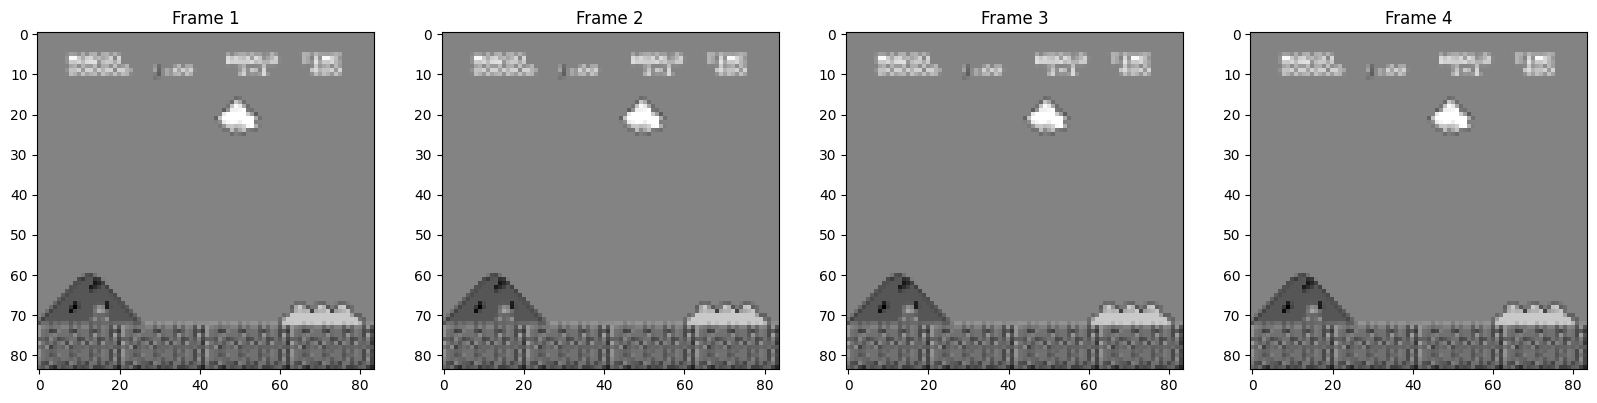

In [21]:
DisplayStackFrames(state_framestacked)

**3.6 Frame Skipping**

In [28]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


env = SkipFrame(env, skip=4)

/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**3.6 Putting All Together**

In [29]:
from gym.wrappers import StepAPICompatibility
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import gym


class FixResetSeedWrapper(gym.Wrapper):
    def __init__(self,env):
        super().__init__(env)
    
    def reset(self,**kwargs):
        # Remove seed and options that JoypadSpace doesn't support
        # Just call reset without any arguments
        result = self.env.reset()
        return result, {}
    
class CustomRenderRGBImage(gym.ObservationWrapper):
    def __init__(self,env):
        super().__init__(env)
        self._last_rgb_image="Exists"
    
    def observation(self,obs):
        self._last_rgb_image = obs.copy()
        return obs
    
    def render_rgb_image(self):
        return self._last_rgb_image




def create_mario_env(level):
    frame_skip=4
    resize_by = 84

    env = gym_super_mario_bros.make(level,new_step_api=True);
    env = JoypadSpace(env, SIMPLE_MOVEMENT);
    env = SkipFrame(env, skip=frame_skip)
    env = GameTimeLimit(env)
    env = CustomRenderRGBImage(env)
    env = GrayScaleObservation(env, keep_dim=True);
    env = ResizeObservation(env, resize_by)
    env = NormalizeObservation(env, new_step_api=True)
    env = FixResetSeedWrapper(env);
    env = StepAPICompatibility(env, new_step_api=True)
    
    return env

#"SuperMarioBros-2-1-v0"
#"SuperMarioBros-v0"

env = DummyVecEnv([lambda: create_mario_env("SuperMarioBros-v0")])
env = VecFrameStack(env, 4, channels_order="last")

state=env.reset()
print("="*100)
print("Shape of state is",state.shape)
print("Number of values returned by Step() : ",len(env.step([1])))
print("="*100)


Shape of state is (1, 84, 84, 4)
Number of values returned by Step() :  4


/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/root/Mario-RL/.venv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


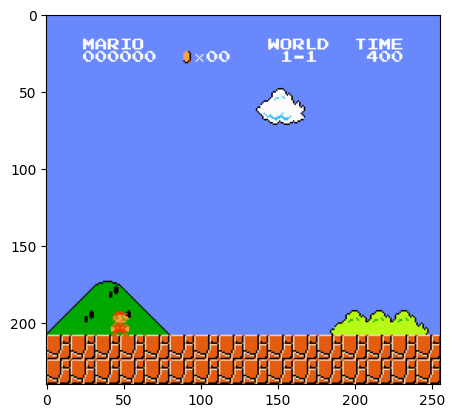

In [ ]:
env.reset()
plt.imshow(env.envs[0].render_rgb_image())

# 4. Proximal Policy Optimisation

Before we dive into the implementation of Proximal Policy Optimisation, we have to talk about it how it works, and why was it used by ChatGPT for training its model

**4.1 Proximal Policy Optimisation**

Also known as (PPO) was first published by OpenAI paper in 2017, it is based on policy gradient methods unlike value methods like Q-learning or Deep Q-Network (DQN), it has two main Neural networks with different jobs

1. Actor Network
2. Critic Network

![Actor Critic](Actor-Critic.png)

In Simple Terms: Actor Network is responsible for taking action, while Critic Network is responsible for giving a feedback for the Actor

Actor is Policy Function Network `π(s,a)` given a state, it provides a probabilistic distribition over set of actions e.g. if you are in state `s1` network produces probability for each action `Action A :25%, Action B:25%, Action C:25%, Action D:25%` all should add up to 100% or 1 if we are using 0.25

Critic is Value Function Network `V(s)` given a state `s` it produces `value for state`

**Training Loop**

1. agent plays game, records all actions and states and rewards and probablities of selected actions in batches/trajectory e.g.
`(state,action,reward,probability)` until episode is Done meaning that game is finished
2. Calculate Target/Gt/Discounted Return, which has the following formuale [that is applied for each single episode/Batch]:
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots$$
3. Critic `V(s)` takes State returns `value for that state` 
4. Advantage Term is estimated using the following formulae:
$$A(s,a) = Q(s,a) - V(s)$$
Where Q(s,a) ≈ Discounted Return Gt, and it is Ground Truth, we can also call it `Target`

5. Interpret Advantage Results:

- $If A(s,a) > 0$ means this action is better than average
- $If A(s,a) < 0$ means this action is worse than average

Another way to think about it is the following example, I (Critic) estimate that taking action `JUMP🍄` will give us 100 rewards, the Ground Truth `What has actually happened/Target` says we got 120 rewards instead for action `JUMP🍄`, we calculate Advantage value for that specific action in that specific state, A(s,`JUMP🍄`) = 120 - 100 = +20, 20 means our action is 20% reward is higher than average that means we should enforce it more

6. Calculating Loss for Critic
we just add up all advantages values for each action in specific state we have selected, Square them and divide them, basically MSE

$$Loss_Critic = \frac{(A1)^2 + (A2)^2 + \cdots }{n}$$

7. Calculating Loss for Actor
now there is an equation for it, do not worry we will go through each term
$$L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min\left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]$$

Where:
- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ is the probability ratio, the higher the new probability of that action is, the higher the ratio is
- $A_t$ is the advantage estimate
- $\epsilon$ is the clipping hyperparameter (typically 0.1-0.3), is used to ensure no destructive large updates takes place, it forces update to small,incremental
- $\text{clip}(x, a, b)$ clips $x$ between $a$ and $b$ where $a$ is lower bound and $b$ is upper bound

in other words this equation increases probability of good actions while decreasing probability of bad actions, which is what `REINFORCE` algorithm do as well

**What Makes PPO Standout?**

it combines both Monte Carlo `Target/Q(s,a)` low bias and low variance of bootstrapping `V(s)` sitting in a good spot, because each one of Monte Carlo  and bootstrapping suffers highly from the opposite type of error

**Why did ChatGPT use PPO?**

because unlike other methods such as DDQN, it is more stable and model updates are not too large leading to instability, this allows model like chatgpt to change its output per each unique user preference, `fine tunning its output based on preference`

In [23]:
from stable_baselines3.common.callbacks import BaseCallback
import os

class TrainAndLoggingCallBack(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallBack, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True) # do not raise an error if the folder already exists
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

CHECKPOINT_DIR="final_models"
LOG_DIR="final_models_logs"
callback = TrainAndLoggingCallBack(check_freq=100000, save_path=CHECKPOINT_DIR)

**4.3 Hyperparameter Tunning Smartly**

we can use brute-force (GridSearch) but according to literature RandomSearchCV most of the times performs better, even more smarter explorting is Bayesian Optimisation, it searches smartly rather than randomly

In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO

class TuneModel:
    def __init__(self, env, total_timesteps=10000, n_eval_episodes=5):
        self.env = env
        self.total_timesteps = total_timesteps
        self.n_eval_episodes = n_eval_episodes

    def ppo_training_objective(self, learning_rate, n_steps, batch_size, 
                              gae_lambda, clip_range, ent_coef, n_epochs, gamma=0.99):
        """
        Objective function for Bayesian Optimization
        Note: This method must take the parameters as arguments
        """
        try:
            # Convert parameters to appropriate types and scales
            learning_rate = 10 ** learning_rate  # Log scale
            n_steps = int(n_steps)
            batch_size = int(batch_size)
            n_epochs = int(n_epochs)
            
            print(f"Training with: lr={learning_rate:.2e}, n_steps={n_steps}, batch_size={batch_size}")
            
            # Create and train model
            model = PPO(
                "CnnPolicy", 
                self.env, 
                learning_rate=learning_rate, 
                n_steps=n_steps,
                batch_size=batch_size,
                gae_lambda=gae_lambda,
                clip_range=clip_range, 
                ent_coef=ent_coef, 
                n_epochs=n_epochs,
                gamma=gamma,
                verbose=0
            )
            
            # Train the model
            model.learn(total_timesteps=self.total_timesteps)
            
            # Evaluate the model
            average_reward, std_reward = evaluate_policy(
                model, 
                self.env, 
                n_eval_episodes=self.n_eval_episodes, 
                deterministic=True
            )
            
            # Clean up
            del model
            
            print(f"Average reward: {average_reward:.2f}")
            return average_reward
            
        except Exception as e:
            print(f"Error in training: {e}")
            return 0.0  # Return minimum reward if training fails

    def setup_bayesian_optimisation(self):
        """Set up Bayesian Optimization with parameter bounds"""
        
        # We need to create a wrapper function that BayesianOptimization can call
        def objective_wrapper(learning_rate, n_steps, batch_size, gamma, 
                            gae_lambda, clip_range, ent_coef, n_epochs):
            return self.ppo_training_objective(
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                clip_range=clip_range,
                ent_coef=ent_coef,
                n_epochs=n_epochs
            )

        pbounds = {
            'learning_rate': (-5, -2),        # 10^-5 to 10^-2
            'n_steps': (64, 2048),            # Number of steps per update
            'batch_size': (32, 256),          # Minibatch size
            'gamma': (0.9, 0.999),            # Discount factor
            'gae_lambda': (0.9, 0.99),        # GAE parameter
            'clip_range': (0.1, 0.3),         # Clipping parameter
            'ent_coef': (0.0, 0.01),          # Entropy coefficient
            'n_epochs': (3, 20)               # Number of optimization epochs
        }

        optimiser = BayesianOptimization(
            f=objective_wrapper,
            pbounds=pbounds, 
            random_state=42, 
            verbose=2
        )

        return pbounds, optimiser
    
    def start_tunning(self, n_iter=15, init_points=5):
        """Start the Bayesian Optimization process"""
        pbounds, optimiser = self.setup_bayesian_optimisation()

        # Run optimization
        optimiser.maximize(n_iter=n_iter, init_points=init_points)

        # Get best results
        best_result = optimiser.max
        
        print("=" * 50)
        print("HYPERPARAMETER TUNING RESULTS")
        print("=" * 50)
        
        for param, value in best_result["params"].items():
            print(f"Parameter: {param:15} Value: {value}")
        
        print("*" * 50)
        print(f"Best Reward: {best_result['target']:.2f}")
        print("=" * 50)
        
        return best_result
    
tuner = TuneModel(
    env=env,
    total_timesteps=10000,  # Short training for quick optimization
    n_eval_episodes=3       # Fewer episodes for faster evaluation
)

tuner.start_tunning()


|   iter    |  target   | learni... |  n_steps  | batch_... |   gamma   | gae_la... | clip_r... | ent_coef  | n_epochs  |
-------------------------------------------------------------------------------------------------------------------------
Training with: lr=1.33e-04, n_steps=1950, batch_size=195
Average reward: 300.67
| 1         | 300.66666 | -3.876379 | 1950.2171 | 195.96664 | 0.9592671 | 0.9140416 | 0.1311989 | 0.0005808 | 17.724994 |
Training with: lr=6.36e-04, n_steps=1468, batch_size=36
Average reward: 680.00
| 2         | 680.0     | -3.196654 | 1468.8159 | 36.610926 | 0.9960210 | 0.9749198 | 0.1424678 | 0.0018182 | 6.1178766 |
Training with: lr=8.18e-05, n_steps=1105, batch_size=128
Average reward: 725.00
| 3         | 725.0     | -4.087273 | 1105.1167 | 128.75568 | 0.9288316 | 0.9550667 | 0.1278987 | 0.0029214 | 9.2281513 |
Training with: lr=2.33e-04, n_steps=1621, batch_size=76
Average reward: 495.00
| 4         | 495.0     | -3.631790 | 1621.7891 | 76.726927 | 0.9509092 

{'target': 737.0,
 'params': {'learning_rate': -4.672253552165803,
  'n_steps': 1102.8898260432752,
  'batch_size': 123.30766009251346,
  'gamma': 0.9,
  'gae_lambda': 0.99,
  'clip_range': 0.1,
  'ent_coef': 0.0,
  'n_epochs': 14.216266664259633}}

In [ ]:
total_timesteps=2000_0000
CHECKPOINT_DIR="/PPO_TRAINED_MODELS"
callback = TrainAndLoggingCallBack(check_freq=100000, save_path=CHECKPOINT_DIR)

In [ ]:
from stable_baselines3 import PPO



model = PPO(
    "CnnPolicy", 
    env,
    learning_rate=2.13e-5,
    n_steps=1103,
    batch_size=123,
    gamma=0.9,
    gae_lambda=0.99,
    clip_range=0.1,
    ent_coef=0.0,
    n_epochs=14,
    verbose=1
)
            
model.learn(total_timesteps=total_timesteps)

Using cuda device
Wrapping the env in a VecTransposeImage.
-----------------------------
| time/              |      |
|    fps             | 51   |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 1103 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 2            |
|    time_elapsed         | 44           |
|    total_timesteps      | 2206         |
| train/                  |              |
|    approx_kl            | 0.0035310239 |
|    clip_fraction        | 0.0711       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -0.00186     |
|    learning_rate        | 2.13e-05     |
|    loss                 | 363          |
|    n_updates            | 14           |
|    policy_gradient_loss | -0.00364     |
|    value_loss           | 867          |


# 5. Evaluate Proximal Policy Optimisation

In [24]:
import imageio
import os

def MakeVideo(all_frames,save_path):
    imageio.mimwrite(save_path,all_frames,fps=30)
    print(f"Saved Video path {save_path}")

In [37]:
VIDEO_FOLDER="rl_ppo_videos"
os.makedirs(VIDEO_FOLDER, exist_ok=True)

def Test_Agent(load_agent=False,model=None,model_name=""):
    if load_agent:
        try:
            model_path = os.path.join(CHECKPOINT_DIR,model_name)
            model=PPO.load(model_path)
        except Exception as e:
            print(f"Failed to Load {model_name}, Error in details : {e}")
            return
    
    state = env.reset()
    done=False

    all_states=[]
    all_actions=[]
    while not done:
        action, _ = model.predict(state)
        
        state, reward, done, info = env.step(action)
        state_rgb=env.envs[0].render_rgb_image();
        all_states.append(state_rgb.copy())
        all_actions.append(action)
    
    model_name_without_zip=model_name.replace(".zip",".mp4")
    video_path = os.path.join(VIDEO_FOLDER,model_name_without_zip)
    print("Video path is",video_path)
    MakeVideo(all_states,video_path)

Test_Agent(model=model,model_name="ppo_100_thousand.zip")

Video path is rl_ppo_videos/ppo_100_thousand.mp4
Saved Video path rl_ppo_videos/ppo_100_thousand.mp4


**5.1 PPO: Trained for 1 million timesteps**

In [ ]:
from IPython.display import Video

Video(f"{VIDEO_FOLDER}//ppo_1_million.mp4")

It seems that it struggles with jumping over small gaps

**5.1 PPO: Trained for 1.5 million timesteps**

In [8]:
Video(f"{VIDEO_FOLDER}//ppo_1_half_million.mp4")

It died twice in the same spot as the first model however on the last live it almost made it through level 1

**5.1 PPO: Trained for 2 million timesteps**

In [9]:
Video(f"{VIDEO_FOLDER}//ppo_2_million.mp4")

It got stuck initally next to first few pipes, running towards them instead of jumping over them, however it made it through level 1, but we can see it struggles with level 2, it is possible that the Model is overfitting on level 1